# SWOT denoising module: description and use

* Emmanuel Cosme, Laura Gómez Navarro, Julien Le Sommer, Nicolas Papadakis, Ananda Pascual, Audrey Monsimer
* Objective: Describe the denoising methods and show how to call them
* Created on March 2018

In [1]:
import time

print('Last update:', time.ctime(time.time())) 


Last update: Wed Feb 26 10:57:30 2020


### Updated in January 2020, by A. Albert

Use of a conda environment configuration file : env_swotmod.yml
```conda env create -f env_swotmod.yml```
then
```conda activate swotmod```

To make it appear on the list of kernels proposed by jupyter :

```python -m ipykernel install --user --name swotmod --display swotmod```

All the libraries needeed ara now installed !

## Descriptions

* Input:
    * FASTtest06 data: SWOT simualtion done for the fast-sampling phase region in the western Mediterranean.  No-gap is specified.
* Outputs:
    * /Users/laura/src/git/swotsimulator/swotoutput/FASTtest06/MED_1km_nogap_JAS12_swotFastPhase_c90_p009_denoised.nc
    * /Users/laura/PhD_private/data/SWOT_box_selections/denoised/test00/MED_1km_nogap_JAS12_swotFastPhase_c90_p009_denoised.nc
<br>**(2 saving output options are shown)**

* Methods: Different methods are tested below.



## 0. Imports, versions, plots, input files

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr

import SWOTdenoise as swotd

# Libraries needed in SWOT module
import netCDF4
import scipy


In [7]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, netcdf4, scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.10 64bit [GCC 7.3.0]
IPython 7.12.0
OS Linux 4.9.0 11 amd64 x86_64 with debian 9.11
numpy 1.18.1
matplotlib 3.1.3
xarray 0.15.0
netcdf4 1.5.3
scipy 1.4.1
Wed Feb 26 11:00:24 2020 CET

###  A function for plots
This function plots a SSH field as read in a SWOT file.
The function calls the fill_nadir_gap function of the SWOTdenoise module, to clearly show the gap. Otherwise, pyplot fills the gap by crudely interpolating the data between the two swaths.

In [8]:
vmin = -0.3
vmax = 0.15

def splot(sshin):
    _, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
    
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    
    cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)
    
    plt.colorbar(cs)

### Inputs

In [9]:
filedir  = 'example_data/'
filename = filedir + 'MED_fastPhase_1km_swotFAST_c01_p009.nc'

## 1. Call the ```SWOTdenoise``` function
The ```SWOTdenoise``` function can be called by providing the SWOT Netcdf file name only. In this case, the denoised field is returned in another Netcdf file named **foo_denoised.nc** if the input file is **foo.nc**. It is created in the same directory.

In [10]:
output_filename = 'None'

In [12]:
swotd.SWOTdenoise(filename, output_filename)

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 25.56
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc


The function can also be called by providing the appropriate arrays as keywords arguments: ```ssh, lon, lat, x_ac, time```. In the example below, these arrays are first read in the SWOT file using the ```read_data``` function of the module:

In [13]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')

ssh_den, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time)


Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 25.56


### Plot the initial SSH field, and the denoised field

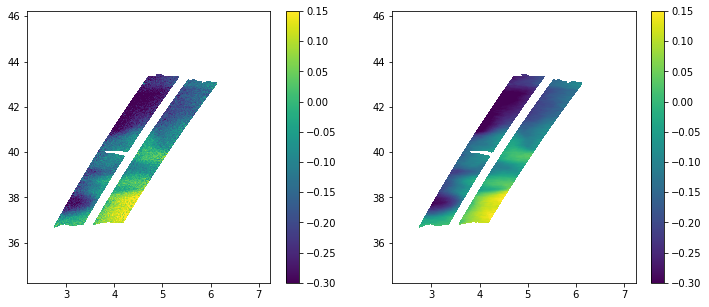

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den)

### For further check, read previously created file and plot SSH:

In [15]:
filename_den = filedir + 'MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc'


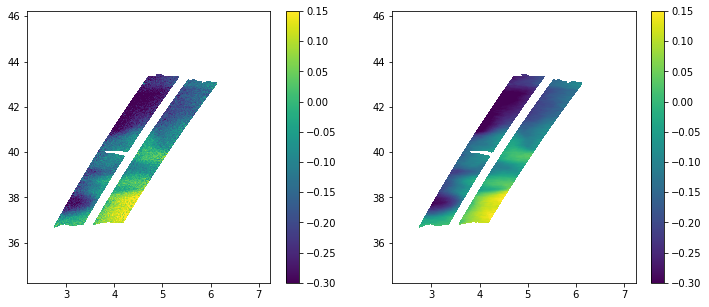

In [16]:
ssh_den2, lon, lat, x_ac, time = swotd.read_data(filename_den, 'SSH', 'lon', 'lat', 'x_ac', 'time')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den2)

# Now trying giving an output_filename instead of the dafault 'None':

In [17]:
outfiledir = filedir 
filename_den = outfiledir + 'MED_fastPhase_1km_swotFAST_c01_p009_denoised_try2.nc'   # created by the module

swotd.SWOTdenoise(filename, filename_den)

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 25.56
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009_denoised_try2.nc


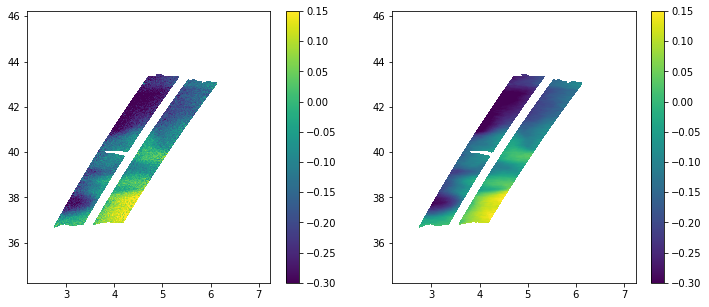

In [18]:
ssh_den2, lon, lat, x_ac, time = swotd.read_data(filename_den, 'SSH', 'lon', 'lat', 'x_ac', 'time')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den2)

## 2. Optional parameters

In addition to the arguments described above, the ```SWOTdenoise``` function takes 5 optional arguments:

- ```method```: ```gaussian```, ```boxcar```, or ```var_reg```;
- ```param```: number for ```gaussian``` and ```boxcar```; 3-entry tuple for ```var_reg```;
- ```itermax```: only for ```var_reg```: maximum number of iterations in the gradient descent algortihm;
- ```epsilon```: only for ```var_reg```: convergence criterium for the gradient descent algortihm;
- ```inpainting```: if ```True```, the nadir gap is inpainted. If ```False```, it is not and the returned SSH array is of the same shape as the original one. If the ```SWOTdenoise``` function is called using arrays (see above description) with ```inpainting=True```, then it returns SSH, lon, and lat arrays. If it is called using arrays with ```inpainting=False```, it returns only SSH, since lon and lat arrays are the same as for the input field.

Without the necessary arguments, denoising is performed using a default method with default parameter(s) identified to be optimal.

## 3. Examples 
Examples below are given using the second method to call the function: giving arrays as arguments. The arrays are first read in the input file using the ```read_data``` function.

In [16]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')

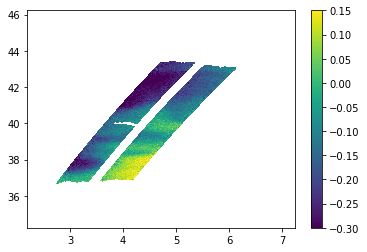

In [17]:
splot(ssh)

### Gaussian filter:

Method: gaussian


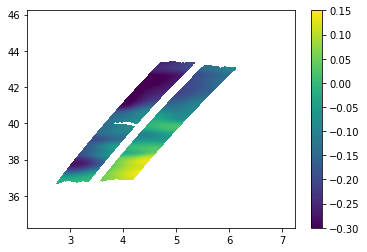

In [18]:
ssh_gau, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='gaussian', param=10.)
splot(ssh_gau)


### Boxcar filter:

Method: boxcar


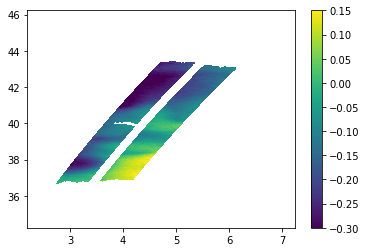

In [19]:
ssh_box, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='boxcar', param=4.)
splot(ssh_box)

### First order (gradients) regularization filter:
The function prints the number of iterations of the gradient descent method, and the convergence ratio. The convergence ratio is defined here as the ratio between the norm of the descent increment and the convergence factor (equal to 1e-9 by default). Iterations stops when the convergence ratio is below 1.

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 92.9


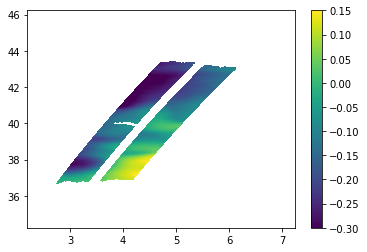

In [20]:
ssh_vr1, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(10.,0,0) )
splot(ssh_vr1)

### Second order (laplacian) regularization filter:

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 27.57


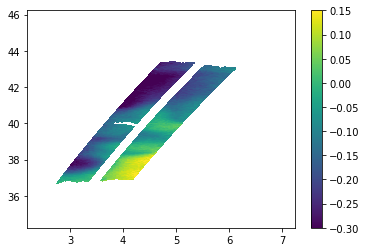

In [21]:
ssh_vr2, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(0,1,0) )
splot(ssh_vr2)

### Third order (gradient of laplacian) regularization filter:

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 38.88


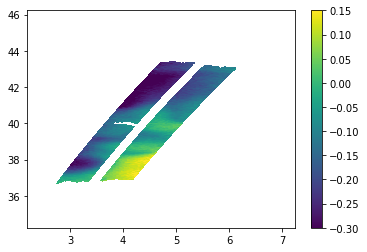

In [22]:
ssh_vr3, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(0,0,1) )
splot(ssh_vr3)

### Combined orders regularization filter:

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 43.19


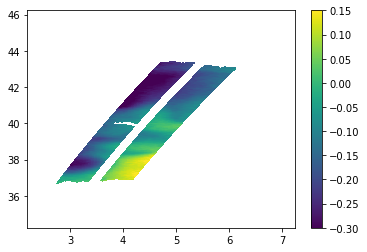

In [23]:
ssh_vr, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(1,2,4) )
splot(ssh_vr)